## psf_image_conv_compareSFandnonSF
Script that runs the image convolution on the EAGLE projections.  Use the profiles that are approximately the Dragonfly PSF: double Moffat with Aureole.

Want to convolve the simulation before reducing to the Dragonfly resolution...

__Input:__<br>
paths to .npz files that are both non-SF and SF

__Output:__<br>
maps of the emission with the PSF convolution for SF and nonSF<br>
comparison of SB profiles with the PSF convolution for SF and nonSF

In [151]:
%run 'extract_FOV.ipynb'
### Need to load those previous two before the image convolution one or else will crash (something contradicts in these)
%run 'psf_image_conv.ipynb'

In [11]:
import os


### some functions from load_data
def changeres(distance,resolution,data):
    """
    distance: one of 50Mpc, 100Mpc, 200Mpc, or 500Mpc
    resolution: desired output resolution (e.g. 14 arcsec, 100 arcsec, 500 arcsec, 1000 arcsec)
    data: the raw data (size 32000 x 32000 pixels, 100 Mpc x 100 Mpc)
    """
    pixscale_tomatchres = {'46Mpc': 0.221/1000.*(1.+0.0107),'92Mpc':0.437/1000.*(1.+0.0215)}
    pixscale            = {'50Mpc': 0.237/1000.*(1.+0.0115), '100Mpc': 0.477/1000.*(1.+0.0235),\
                           '200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12),\
                           '980Mpc': 3.825/1000.*(1.+0.24)} ### Mpc / arcsec (comoving)
    size = 32000. # pixels 
    scale = 100.  # Mpc 
    
    if distance in pixscale:
        simpixsize = scale/size ### Mpc / pixel is resolution of raw data 
        factor = round(pixscale[distance]*resolution/simpixsize)
        print("Will reduce resolution by a factor of %s."%factor)
        # LATER determine the current resolution of the data. FOR NOW assume current resolution is 100 Mpc/ 32000 pixels ~ 3 kpc/pixel

        'If the factors are not integer multiples of the size (32000), trim the data first and then imreduce it'
        if size%((factor)) != 0.:
            times_factor_fits_in = int(size/factor)
            newsize = times_factor_fits_in * factor
            print("Before reducing resolution, the original data was trimmed to size %s."%newsize)
            datanew = data[0:int(newsize),0:int(newsize)]
        else:
            datanew = data
            newsize = size
    else:
        print('distance needs to be one of: 50Mpc, 100Mpc, 200Mpc, 500Mpc, or 980Mpc.  Others not supported atm.')
        return None
    
    if factor < 2.:
        return datanew, newsize, factor
    else:
        return imreduce(datanew, round(factor), log=True, method = 'average'), newsize, factor


def find_output_resolution(distance,DragonflyTelescope):
    """
    inputs:
    distance: one of 50Mpc, 100Mpc, 200Mpc, or 500Mpc
    data: the raw data (size 32000 x 32000 pixels, 100 Mpc x 100 Mpc)
    """
    pixscale_tomatchres = {'46Mpc': 0.221/1000.*(1.+0.0107),'92Mpc':0.437/1000.*(1.+0.0215)}
    pixscale            = {'50Mpc': 0.237/1000.*(1.+0.0115), '100Mpc': 0.477/1000.*(1.+0.0235),\
                           '200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12),\
                           '980Mpc': 3.825/1000.*(1.+0.24)} ### Mpc / arcsec (comoving)
    res_Dragonfly = 2.8 # arcsec / pixel
    ## For now, assuming that the size and scale of the simulation is that of the raw simulation: 100Mpc/32000pixels
    size = 32000. # pixels 
    scale = 100.  # Mpc 
    
    if distance in pixscale:
        simpixsize = scale/size ### Mpc / pixel is physical resolution of raw data
        'calculate the resolution of the raw simulation at the distance specified'
        resolution = simpixsize / pixscale[distance] ### (Mpc / pixel) / (Mpc / arcsec) = arcsec/pixel is angular resolution of raw data
        print("The resolution of the raw simulation at %s is %s."%(distance,resolution))
        
        if resolution < res_Dragonfly and DragonflyTelescope:
            factor = round(res_Dragonfly/resolution)
            print ("%s is less than the Dragonfly resolution (%s) so (if resolution = None) would bin data by %s."\
                   % (resolution, res_Dragonfly, factor))
            resolution = resolution*factor
            print ("Final resolution would be %s" % resolution)
        return resolution
    else:
        print('distance needs to be one of: 50Mpc, 100Mpc, 200Mpc, 500Mpc, or 980Mpc.  Others not supported atm.')
        return None

def loaddata(machine):
    homedir=''
    if machine=='chinook':
        homedir='/Users/lokhorst/Eagle/'
    elif machine=='coho':
        homedir='/Users/deblokhorst/eagle/SlicesFromNastasha/'
    ## Add the path to where the raw data is kept on your computer here
    
    files_SF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5__fromSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5__fromSFR.npz']

    files_noSF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5_noSFR.npz',
                    homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5_noSFR.npz']
    
    file_SF_28 = homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_total_fromSFR.npz'
    file_noSF_28 = homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_20slice_total_noSFR.npz'

    if os.path.isfile(file_SF_28):
        print 'Total fromSFR file exists, loading now...'
        halpha_fromSF = np.load(file_SF_28)['arr_0']
    else:
        print 'Total fromSFR file doesnt exist, making it now...'
        halpha_fromSF = np.load(files_SF_28[0])['arr_0']
        for filename in files_SF_28[1:]:
            print 'adding: '+filename
            halpha_fromSF = np.log10(10**halpha_fromSF + 10**(np.load(filename)['arr_0']))
        print 'Saving total fromSFR file to: %s'%file_SF_28
        np.savez(file_SF_28,halpha_fromSF)

    if os.path.isfile(file_noSF_28):
        print 'Total noSFR file exists, loading now...'
        halpha_noSF = np.load(file_noSF_28)['arr_0']
    else:
        print 'Total noSFR file doesnt exist, making it now...'
        halpha_noSF = np.load(files_noSF_28[0])['arr_0']
        for filename in files_noSF_28[1:]:
            print 'adding: '+filename
            halpha_noSF = np.log10(10**halpha_noSF + 10**(np.load(filename)['arr_0']))
        print 'Saving total noSFR file to: %s'%file_noSF_28
        np.savez(file_noSF_28,halpha_noSF)

    return halpha_fromSF,halpha_noSF

In [3]:
halpha_fromSF,halpha_noSF = loaddata('coho')

Total fromSFR file exists, loading now...
Total noSFR file exists, loading now...


In [4]:
halpha_total = np.log10(10**halpha_fromSF + 10**halpha_noSF)

I want to just crop out a smaller region from the box, though, let's extract approximately *four times* the Dragonfly FOV at 50 Mpc (but has to be square because that's what the image convolution script expects).  Making it bigger than the Dragonfly FOV because the FFT does a periodic thing (of course) so the edges are gonna be funky.  Wanna crop those out.

In [9]:
distance = '50Mpc'; z = 0.0115;
resolution = find_output_resolution(distance,True)
fwhm = 3.0*arcsec

The resolution of the raw simulation at 50Mpc is 13.0357429643.


In [12]:
data_tuple = changeres(distance,resolution,halpha_total)
print data_tuple

Will reduce resolution by a factor of 1.0.
(array([[-2.62077165, -2.62564492, -2.63008714, ..., -2.60400987,
        -2.60988569, -2.61549926],
       [-2.61682892, -2.62165117, -2.62603855, ..., -2.60022879,
        -2.60604382, -2.61160588],
       [-2.61321545, -2.61798644, -2.62232208, ..., -2.59680223,
        -2.60254669, -2.60804701],
       ..., 
       [-2.63436723, -2.63937879, -2.64398909, ..., -2.61722207,
        -2.62324286, -2.62897539],
       [-2.62957716, -2.63454533, -2.63909984, ..., -2.61254859,
        -2.61852527, -2.62422156],
       [-2.62503099, -2.62995338, -2.63445163, ..., -2.60812998,
        -2.61405802, -2.61971521]], dtype=float32), 32000.0, 1.0)


In [13]:
dragonfly_fov = 1440. #arcsec
factor_bigger = 4.
data_FOV_total, xystarts_out, size_out = extractFOV(data_tuple, None, distance, 
                                                    x_center = 50.5, y_center = 13.5,
                                                    x_angFOV=dragonfly_fov*factor_bigger,
                                                    y_angFOV=dragonfly_fov*factor_bigger)

In [14]:
numpix = data_FOV_total.shape[0]
boxlength = size_out[0]
print numpix, boxlength

442 1.38125


STARTING convolution...
img shape: (442,442), boxlength: 1.38125 Mpc,numpix: 442,z: 0.0115,kernel: 2MoffatAureole,fwhm: 1.45443967711e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45443967711e-05, beta 7.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

DEBUGGING: Integral of kernel (not normalized yet): 26360305077.8
Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



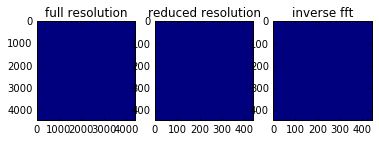

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45443967711e-05, beta 2.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

DEBUGGING: Integral of kernel (not normalized yet): 26364667454.8
Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



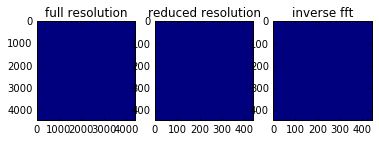

 FINISHED generate_abr_fftkernel.



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in log10


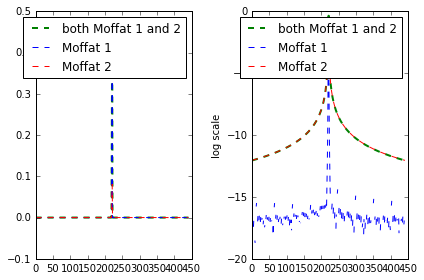

 STARTING generate_abr_fftkernel for fwhm 1.45443967711e-05, beta 7.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (not normalized yet): 238362263.267
DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



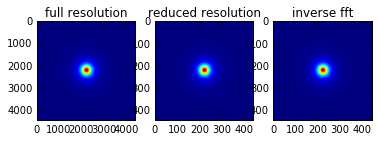

 FINISHED generate_abr_fftkernel.


The sum of flux before the convolution is: 3.62114e+08
The sum of flux after the convolution is: 362113693.2

FINISHED convolution.


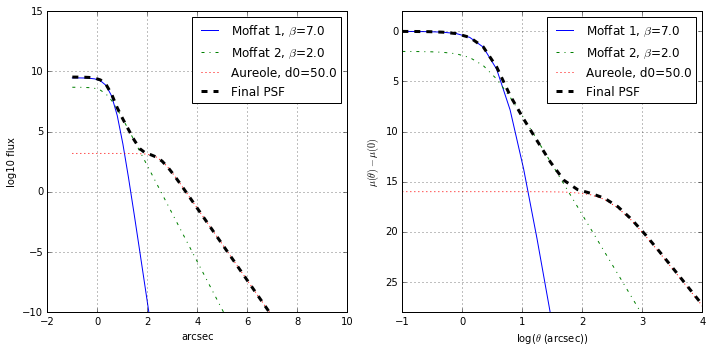

In [152]:
#%run 'psf_image_conv.ipynb'
convolved_withSF = conv_image_abr(10**data_FOV_total,boxlength,numpix,z,'2MoffatAureole',fwhm,
                                    debug=True,plotchecks=True)

Will reduce resolution by a factor of 1.0.
STARTING convolution...
img shape: (442,442), boxlength: 1.38125 Mpc,numpix: 442,z: 0.0115,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

DEBUGGING: Integral of kernel (not normalized yet): 26360305073.8
Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



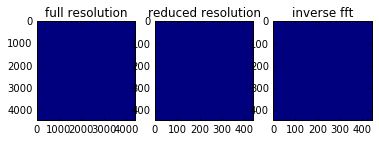

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

DEBUGGING: Integral of kernel (not normalized yet): 26364667406.7
Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



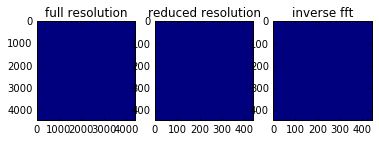

 FINISHED generate_abr_fftkernel.



/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: invalid value encountered in log10


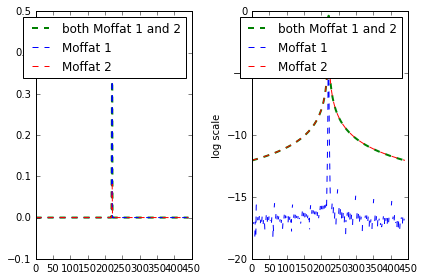

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
DEBUGGING: comoving distance (cm): 1.56557514321e+26
DEBUGGING: longlen (the boxlength in cm): 4.2620927375e+24
DEBUGGING: adist (comoving distance divided by cosmological factor): 1.5477757224e+26
DEBUGGING: image angle per pixel (arcsec): 12.7043441397
 Calculting PSF.

Reducing psf by factor of 10.0 

DEBUGGING: Integral of kernel (not normalized yet): 238362239.783
DEBUGGING: Integral of kernel (normalized): 1.0
 Fourier transforming PSF.



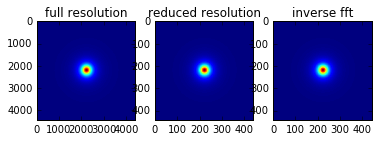

 FINISHED generate_abr_fftkernel.


The sum of flux before the convolution is: 2.48748e+08
The sum of flux after the convolution is: 248747611.012

FINISHED convolution.


In [16]:
data_tuple = changeres(distance,resolution,halpha_noSF)
data_FOV_noSF, xystarts_out, size_out = extractFOV(data_tuple, None, distance, 
                                                    x_center = 50.5, y_center = 13.5,
                                                    x_angFOV=dragonfly_fov*factor_bigger,
                                                    y_angFOV=dragonfly_fov*factor_bigger)
numpix = data_FOV_noSF.shape[0]
boxlength = size_out[0]
convolved_noSF = conv_image_abr(10**data_FOV_noSF,boxlength,numpix,z,'2MoffatAureole',fwhm,
                                debug=True,plotchecks=True)

In [165]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

import os

def makemap(data,size,ax,colmap='viridis',xystarts = [0.,0.],title = '',colorbar=True,mockobs=False,labelaxes=True,label='',Vmin = None, Vmax = None):
    fontsize=13
    #xystarts = [0.,0.] # lower left origin of the plot
    
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    
    if type(size) == float or type(size) == int:
        print('The type of size is '+str(type(size)))
        xsize = size
        ysize = size
    else:
        print('The type of size is '+str(type(size)))
        xsize = size[0]
        ysize = size[1]
    
    #fig = plt.figure(figsize = (5.5, 5.)) # large size just as a trick to get higher resolution
    #fig = plt.figure(figsize = (11., 10.))
    #ax = plt.subplot(111)
    
    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        #ax.xaxis.set_label_position('top') 
        ax.xaxis.set_label_position('bottom') 
        #ax.xaxis.tick_top()
        #ax.minorticks_on()
    else:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_xticks([])
        ax.set_yticks([])
    
    colmap = 'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
    
    # nearest neighbour interpolation does not do any averaging, it just picks the nearest point and uses that as the value for a specific section in the image
    img = ax.imshow(data.T,extent=(xystarts[0],xystarts[0]+xsize,xystarts[1],xystarts[1]+ysize),origin='lower', 
                    cmap=cm.get_cmap(colmap),interpolation='nearest', vmin = Vmin, vmax=Vmax)
    
    #plt.title(label,fontsize=fontsize)
    div = axgrid.make_axes_locatable(ax)
        
    if colorbar:
        #cax = div.append_axes("right",size="5%",pad=0.1)
        
        # bottom color bar:
        #cax = div.append_axes("bottom",size="15%",pad=0.1)
        #cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
        
        # top color bar:
        cax = div.append_axes("top",size="5%",pad=0.1)
        cbar = plt.colorbar(img, cax=cax,orientation='horizontal')

        cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.xaxis.set_label_position('top')      
        cbar.ax.xaxis.set_ticks_position('top')
        cbar.solids.set_edgecolor("face")
        #cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
        cbar.ax.tick_params(labelsize=fontsize)
    
    font = {'family': 'serif',
        'color':  'yellow',
        'weight': 'bold',
        'size': 12,
        }
    
    font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 12,
        }


The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>


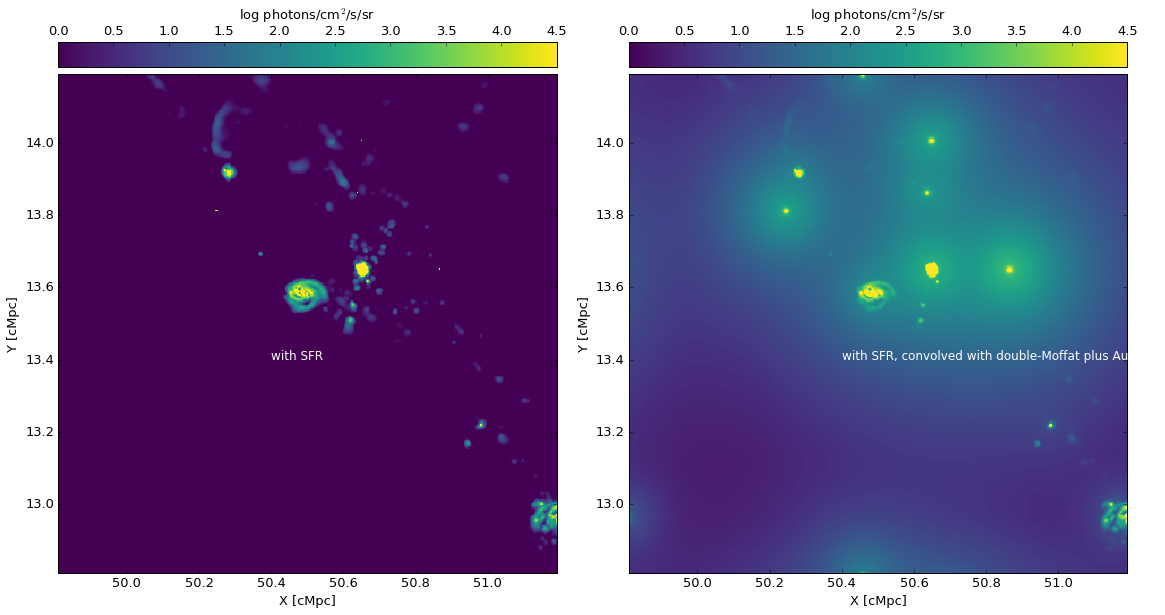

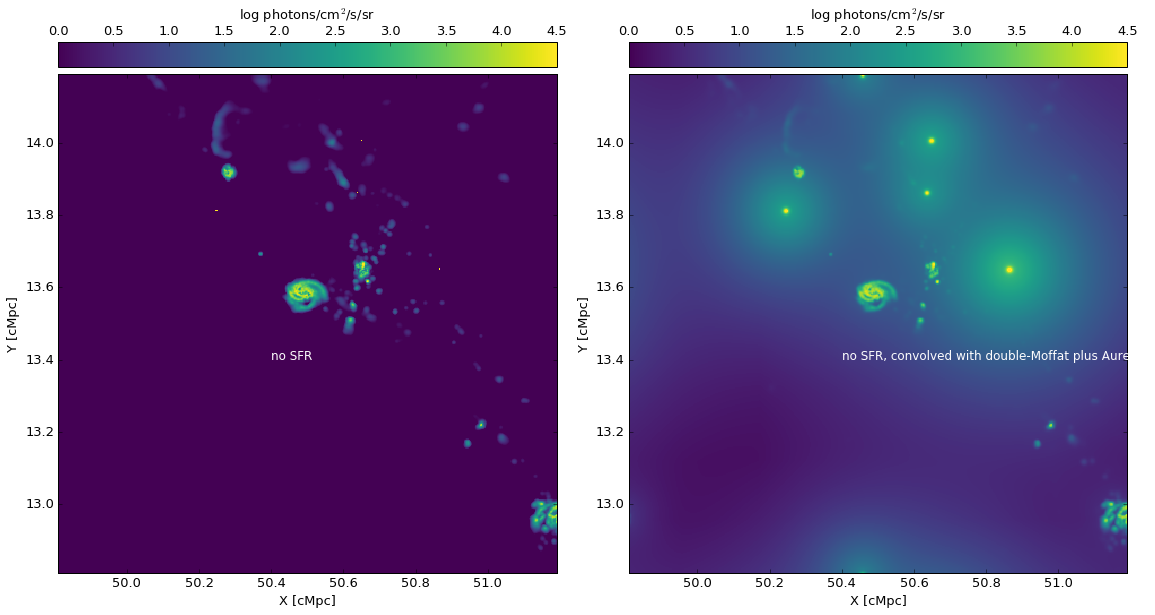

In [166]:
vmin=0; vmax=4.5
# with SFR
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.
makemap(data_FOV_total,size_out,ax1,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax1.text(50.40,13.40,'with SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_withSF)),size_out,ax2,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax2.text(50.40,13.40,'with SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)
plt.tight_layout()

# no SFR 
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.
makemap(data_FOV_noSF,size_out,ax1,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax1.text(50.40,13.40,'no SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_noSF)),size_out,ax2,xystarts = xystarts_out,Vmin=vmin,Vmax=vmax)
ax2.text(50.40,13.40,'no SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)
plt.tight_layout()

In [167]:
numz = 8

xystarts_small = [xystarts_out[0]+size_out[0]/numz/2,xystarts_out[1]+size_out[1]/numz/2]
size_small = [size_out[0]/numz/2, size_out[1]/numz/2]
bounds = [data_FOV_total.shape[0]/2-data_FOV_total.shape[0]/numz,data_FOV_total.shape[0]/2+data_FOV_total.shape[0]/numz,\
          data_FOV_total.shape[1]/2-data_FOV_total.shape[1]/numz,data_FOV_total.shape[0]/2+data_FOV_total.shape[1]/numz]
print xystarts_out
print xystarts_small
print size_out
print bounds

[49.809375, 12.809375000000001]
[49.895703125000004, 12.895703125]
[1.3812499999999943, 1.3812499999999996]
[166, 276, 166, 276]


The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>
The type of size is <type 'list'>
The maximum value in the with SF plots is: 8.12389


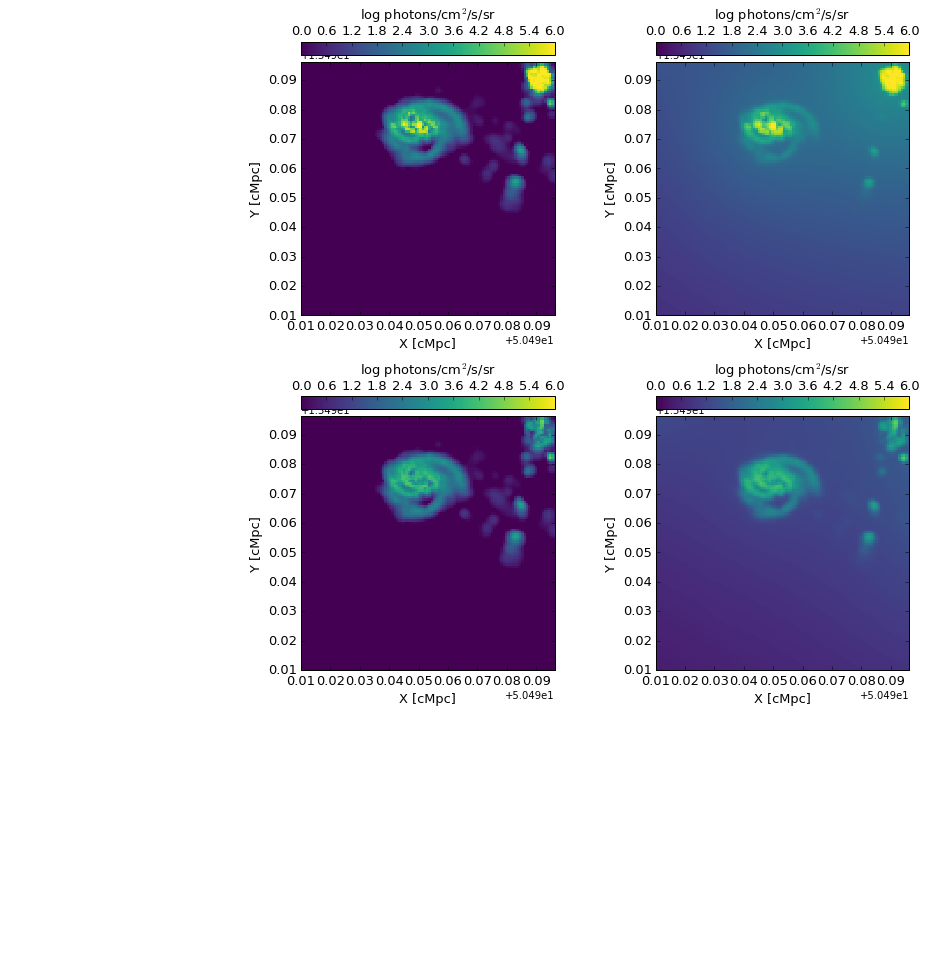

In [172]:
vmin=0; vmax=6
# with SFR
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2, 2, figsize=(10, 10))

xystarts_small = [xystarts_out[0]+size_out[0]/2,xystarts_out[1]+size_out[1]/2]

#get_halpha_SB.
makemap(data_FOV_total[bounds[0]:bounds[1],bounds[2]:bounds[3]],size_small,ax1,\
        xystarts = xystarts_small,Vmin=vmin,Vmax=vmax)
ax1.text(50.40,13.40,'with SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_withSF))[bounds[0]:bounds[1],bounds[2]:bounds[3]],size_small,ax2,\
        xystarts = xystarts_small,Vmin=vmin,Vmax=vmax)
ax2.text(50.40,13.40,'with SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)

# no SFR 
#fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 16))
#get_halpha_SB.
makemap(data_FOV_noSF[bounds[0]:bounds[1],bounds[2]:bounds[3]],size_small,ax3,\
        xystarts = xystarts_small,Vmin=vmin,Vmax=vmax)
ax3.text(50.40,13.40,'no SFR',color='white',fontsize=12)
#get_halpha_SB.
makemap(np.log10(np.fft.fftshift(convolved_noSF))[bounds[0]:bounds[1],bounds[2]:bounds[3]],size_small,\
        ax4,xystarts = xystarts_small,Vmin=vmin,Vmax=vmax)
ax4.text(50.40,13.40,'no SFR, convolved with double-Moffat plus Aureole',color='white',fontsize=12)
plt.tight_layout()

print "The maximum value in the with SF plots is: %s"%np.max(data_FOV_total)

[49.809375, 12.809375000000001]
[50.5, 13.5]
[1.3812499999999943, 1.3812499999999996]
[110, 331, 110, 331]


In [36]:
distance = '50Mpc'; z = 0.0115;
resolution = find_output_resolution(distance,True)
fwhm = 3.0*arcsec

numpix = 10
img = np.zeros((numpix,numpix))
img[numpix/2,numpix/2] = 100  #img[numpix/2-2:numpix/2+2,numpix/2-2:numpix/2+2] = 1

boxlength = numpix * 0.003125

print 'For %s pixels a side, the length along the side is %s Mpc.'\
    %(numpix,boxlength)

The resolution of the raw simulation at 50Mpc is 13.0357429643.
For 10 pixels a side, the length along the side is 0.03125 Mpc.


STARTING convolution...
img shape: (10,10), boxlength: 0.03125 Mpc,numpix: 10,z: 0.0115,kernel: 2MoffatAureole,fwhm: 1.45444104333e-05 arcsec. 

af: 0.02,mf: 0.98, m1f: 0.8,beta1: 7.0,beta2: 2.0,d0: 50.0
 Generating the 2Moffat or 2MoffatAureole kernel...

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.



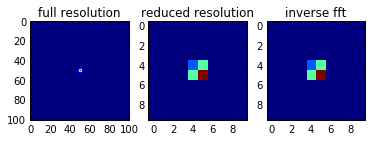

 FINISHED generate_abr_fftkernel.

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 2.0...
 Calculting PSF.

 Fourier transforming PSF.



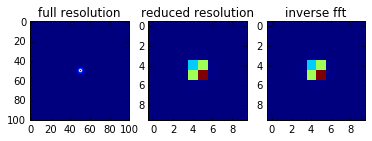

 FINISHED generate_abr_fftkernel.



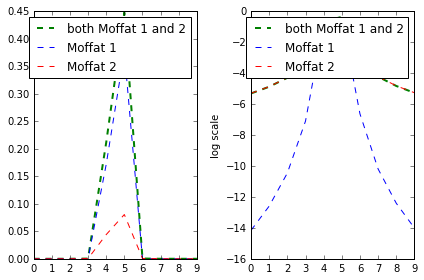

 STARTING generate_abr_fftkernel for fwhm 1.45444104333e-05, beta 7.0...
 Calculting PSF.

 Fourier transforming PSF.



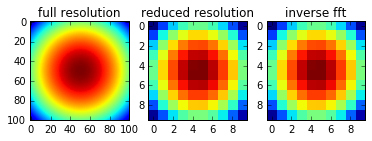

 FINISHED generate_abr_fftkernel.

FINISHED convolution.


In [46]:
convolved_withSF = conv_image_abr(img,boxlength,numpix,z,'2MoffatAureole',fwhm,
                                    debug=False,plotchecks=True)

/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


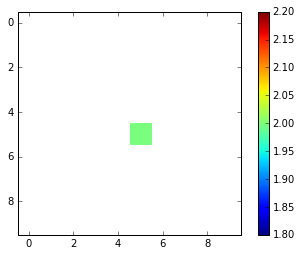

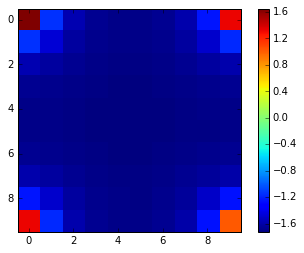

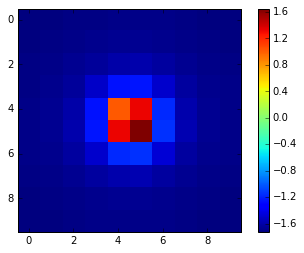

In [48]:
plt.imshow(np.log10(img),interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(np.log10(convolved_withSF),interpolation='nearest')
plt.colorbar()
plt.show()

plt.imshow(np.log10(np.fft.fftshift(convolved_withSF)),interpolation='nearest') #https://dsp.stackexchange.com/questions/47249/result-of-inverse-fft-is-sometimes-shifted-in-real-space
plt.colorbar()
plt.show()

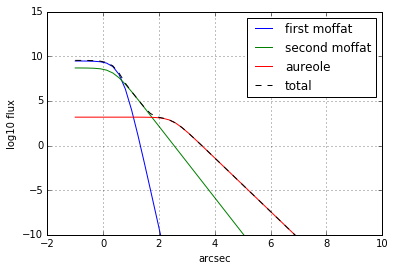

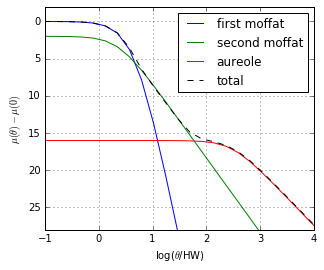

In [119]:
#theta = np.arange(0,100,0.1)
theta = 10.0**np.linspace(-1.0, 10.0, 50)  # arcsec
fwhm = 3./206265.
flux1 = 0.98*0.8*moffat(theta/206265, fwhm, beta=7)
flux2 = 0.98*0.2*moffat(theta/206265, fwhm, beta=2)
flux3 = 0.02*aureole_profile(theta/206265, fwhm, 50.)
fluxtotal = flux1+flux2+flux3

## for mag2 and mag3, adding constant value to push them down a bit -- not exactly sure where these come from,
## used the value from the aureole from Bob and Bob doesn't plot the moffat 2 by itself, so just guessed that one
mag1 = 2.5*np.log10(flux1[0])-2.5*np.log10(flux1)         # Moffat 1
mag2 = 2 + 2.5*np.log10(flux2[0])-2.5*np.log10(flux2)         # Moffat 2
mag3 = 16. + 2.5*np.log10(flux3[0])-2.5*np.log10(flux3)         # Aureole
magtotal = 2.5*np.log10(fluxtotal[0])-2.5*np.log10(fluxtotal)         

## First plot in flux
fig, ax1 = plt.subplots(1,1)
ax1.plot(np.log10(theta), np.log10(flux1), label='first moffat')
ax1.plot(np.log10(theta), np.log10(flux2), label='second moffat')
ax1.plot(np.log10(theta), np.log10(flux3), label='aureole')
ax1.plot(np.log10(theta), np.log10(fluxtotal),'k--', label='total')
ax1.set_ylim(-10,15)
ax1.set_ylabel('log10 flux')
ax1.set_xlabel('arcsec')
ax1.grid()
ax1.legend()

## Second plot in mags
### need to add weird formatting stuff if want to plot exactly the same way as Bob (with mags and such)
fig, ax2 = plt.subplots(1,1)
ax2.plot(np.log10(theta), mag1, label='first moffat')
ax2.plot(np.log10(theta), mag2, label='second moffat')
ax2.plot(np.log10(theta), mag3, label='aureole')
ax2.plot(np.log10(theta), magtotal,'k--', label='total')
ax2.grid()
ax2.legend()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.gca().set_ylim(ymin=-2)
    plt.gca().set_ylim(ymax=28)
    plt.gca().set_xlim(xmin=-1)
    plt.gca().set_xlim(xmax=4)
    xl0,xl1 = plt.gca().get_xlim()
    yl0,yl1 = plt.gca().get_ylim()
    plt.gca().set_aspect(0.83*(xl1-xl0)/(yl1-yl0))
    plt.gca().set_xlabel(r'log($\theta$/HW)')
    plt.gca().set_ylabel(r'$\mu(\theta) - \mu(0)$')
    plt.gca().invert_yaxis()
    plt.legend()

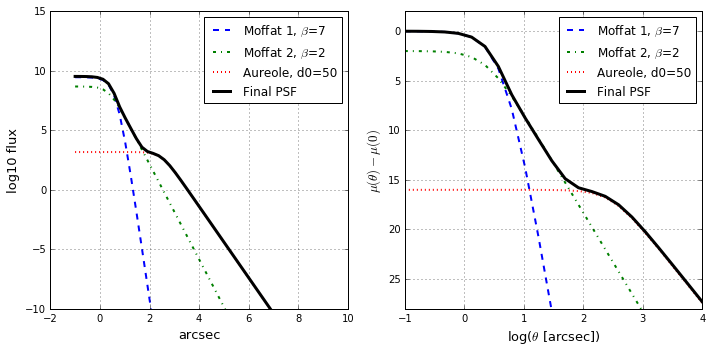

In [163]:
def makethisplot(label1='',label2='',label3=''):
    xxx = 10.0**np.linspace(-1.0, 10.0, 50)  # arcsec
    fwhm = 3./206265.
    beta1 = 7
    beta2 = 2
    d0 = 50
    label1=r'Moffat 1, $\beta$=%s'%beta1
    label2=r'Moffat 2, $\beta$=%s'%beta2
    label3=r'Aureole, d0=%s'%d0
    flux1 = 0.98*0.8*moffat(xxx/206265, fwhm, beta=beta1)
    flux2 = 0.98*0.2*moffat(xxx/206265, fwhm, beta=beta2)
    flux3 = 0.02*aureole_profile(xxx/206265, fwhm, d0)
    fluxtotal = flux1+flux2+flux3

    ## for mag2 and mag3, adding constant value to push them down a bit -- not exactly sure where these come from,
    ## used the value from the aureole from Bob and Bob doesn't plot the moffat 2 by itself, so just guessed that one
    mag1 = 2.5*np.log10(flux1[0])-2.5*np.log10(flux1)         # Moffat 1
    mag2 = 2 + 2.5*np.log10(flux2[0])-2.5*np.log10(flux2)         # Moffat 2
    mag3 = 16. + 2.5*np.log10(flux3[0])-2.5*np.log10(flux3)         # Aureole
    magtotal = 2.5*np.log10(fluxtotal[0])-2.5*np.log10(fluxtotal)         
    
    ## First plot in flux
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
    ax1.plot(np.log10(xxx), np.log10(flux1), 'b--',linewidth=2, label=label1)
    ax1.plot(np.log10(xxx), np.log10(flux2), 'g-.',linewidth=2, label=label2)
    ax1.plot(np.log10(xxx), np.log10(flux3), 'r:', linewidth=2,label=label3)
    ax1.plot(np.log10(xxx), np.log10(fluxtotal),'k-', linewidth=3, label='Final PSF')
    ax1.set_ylim(-10,15)
    ax1.set_ylabel('log10 flux',fontsize = 13)
    ax1.set_xlabel('arcsec',fontsize = 13)
    ax1.grid()
    ax1.legend()

    ## Second plot in mags
    ### need to add weird formatting stuff if want to plot exactly the same way as Bob (with mags and such)
    #fig, ax2 = plt.subplots(1,1)
    ax2.plot(np.log10(xxx), mag1,'b--',linewidth=2, label=label1)
    ax2.plot(np.log10(xxx), mag2,'g-.',linewidth=2, label=label2)
    ax2.plot(np.log10(xxx), mag3, 'r:',linewidth=2,label=label3)
    ax2.plot(np.log10(xxx), magtotal,'k-', linewidth=3,label='Final PSF')
    ax2.set_ylim(28,-2)
    ax2.set_xlim(-1,4)
    ax2.set_xlabel(r'log($\theta$ [arcsec])',fontsize = 13)
    ax2.set_ylabel(r'$\mu(\theta) - \mu(0)$',fontsize = 13)
    #ax2.invert_yaxis()
    ax2.grid()
    ax2.legend()

    plt.tight_layout()

makethisplot()
plt.savefig('psf_image_conv_compare_psfs.png')